# Bloomburrow Card Data EDA

Goals for this notebook:

1. Determine structure of Scryfall card data generally (what columns we'll want and so on)
2. Explore Bloomburrow set specifically (keywords, mana curve, power/toughness, etc)

In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import ast # For safely evaluating string representations of dictionaries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from scripts import get_card_data

blb_df = get_card_data("blb")

#blb_df['name'].head(2)
blb_df.head(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Retrieved Bloomburrow data from memory.


,object,id,oracle_id,multiverse_ids,mtgo_id,arena_id,tcgplayer_id,cardmarket_id,name,lang,...,related_uris,purchase_uris,power,toughness,all_parts,security_stamp,promo_types,frame_effects,produced_mana,loyalty
0,card,7dd9946b-515e-4e0d-9da2-711e126e9fa6,7b89b7d2-c724-4d5d-9f0b-7d3302ad1168,[669036],129489.0,91658.0,559491.0,778435.0,Agate Assault,en,...,{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://partner.tcgplayer.com/c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,39ebb84a-1c52-4b07-9bd0-b360523b3a5b,381a3e8e-71dd-48e4-ab62-53478bde4a14,[668996],129409.0,91618.0,559647.0,778511.0,Agate-Blade Assassin,en,...,{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://partner.tcgplayer.com/c...,1,3,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
core_card_data = ["name", "mana_cost", "cmc", "type_line", "oracle_text", "colors", "color_identity", "keywords", "rarity", "power", "toughness"]
skeptical_keepers = ["reprint"]
external_references = ["oracle_id", "multiverse_ids", "mtgo_id", "arena_id", "tcgplayer_id", "cardmarket_id"]
status_and_printing = ["foil", "nonfoil", "promo", "variation", "security_stamp", "frame", "full_art", "textless"]
art_and_flavor = ["artist", "illustration_id", "flavor_text", "border_color"]
marketplace_and_pricing = ["purchase_uris", "related_uris"]
metadata_and_links = ["set", "set_name", "set_type", "set_uri", "set_search_uri", "scryfall_set_uri", "rulings_uri", "prints_search_uri", "collector_number"]

drop_list = external_references + status_and_printing + art_and_flavor + marketplace_and_pricing + metadata_and_links

blb_df = blb_df.drop(columns=drop_list, errors='ignore')
blb_df.shape
blb_df.columns

Index(['object', 'id', 'name', 'lang', 'released_at', 'uri', 'scryfall_uri',
       'layout', 'highres_image', 'image_status', 'image_uris', 'mana_cost',
       'cmc', 'type_line', 'oracle_text', 'colors', 'color_identity',
       'keywords', 'legalities', 'games', 'reserved', 'game_changer',
       'finishes', 'oversized', 'reprint', 'set_id', 'digital', 'rarity',
       'card_back_id', 'artist_ids', 'booster', 'story_spotlight',
       'edhrec_rank', 'penny_rank', 'preview', 'prices', 'power', 'toughness',
       'all_parts', 'promo_types', 'frame_effects', 'produced_mana',
       'loyalty'],
      dtype='object')

In [7]:
#useless
adtl_droplist = ['object', 'id', 'uri', 'scryfall_uri', 'highres_image', 'image_status',
                 'image_uris', 'reserved', # reserved would be useful but all false
                 'finishes', 'oversized', 'set_id', 'digital', 'card_back_id', 
                 'artist_ids', 'games', 'story_spotlight',
                 'legalities', #theoretically useful to know if a card has been banned,
                 'edhrec_rank', # Theoretically useful
                 'loyalty', # starting 'health' of planeswalkers, only one in the set =4
                 'promo_types', 'all_parts', 'frame_effects', 'lang', 'preview',
                 'released_at', 
                 ]

#maybe
next_drop = []


#useful to clean up rows?
row_cleanup_cols = [
                    'booster', # if false drop
                    ]

blb_df = blb_df.drop(columns=adtl_droplist, errors='ignore')
blb_df.columns

Index(['name', 'layout', 'mana_cost', 'cmc', 'type_line', 'oracle_text',
       'colors', 'color_identity', 'keywords', 'game_changer', 'reprint',
       'rarity', 'booster', 'penny_rank', 'prices', 'power', 'toughness',
       'produced_mana'],
      dtype='object')

In [8]:
#
# Reset the index, turning 'name' into a regular column
if blb_df.index.name == 'name':
    blb_df = blb_df.reset_index()
    print("Index 'name' was reset and converted to a regular column.")
#blb_df['produced_mana'].value_counts()

further_drop = ['layout', #layout is just the "Talent" cards
                'game_changer', #theoretically should be useful, but all false
                ]

blb_df = blb_df.drop(columns=further_drop, errors='ignore')
blb_df.head()

,name,mana_cost,cmc,type_line,oracle_text,colors,color_identity,keywords,reprint,rarity,booster,penny_rank,prices,power,toughness,produced_mana
0,Agate Assault,{2}{R},3.0,Sorcery,Choose one —\n• Agate Assault deals 4 damage t...,['R'],['R'],[],False,common,True,13345.0,"{'usd': '0.03', 'usd_foil': '0.06', 'usd_etche...",NaN,NaN,NaN
1,Agate-Blade Assassin,{1}{B},2.0,Creature — Lizard Assassin,"Whenever this creature attacks, defending play...",['B'],['B'],[],False,common,True,NaN,"{'usd': '0.03', 'usd_foil': '0.07', 'usd_etche...",1,3,NaN
2,A-Heartfire Hero,{R},1.0,Creature — Mouse Soldier,Valiant — Whenever Heartfire Hero becomes the ...,['R'],['R'],['Valiant'],False,uncommon,False,NaN,"{'usd': None, 'usd_foil': None, 'usd_etched': ...",0,1,NaN
3,"Alania, Divergent Storm",{3}{U}{R},5.0,Legendary Creature — Otter Wizard,"Whenever you cast a spell, if it's the first i...","['R', 'U']","['R', 'U']",[],False,rare,True,NaN,"{'usd': '0.08', 'usd_foil': '0.20', 'usd_etche...",3,5,NaN
4,Alania's Pathmaker,{3}{R},4.0,Creature — Otter Wizard,"When this creature enters, exile the top card ...",['R'],['R'],[],False,common,True,NaN,"{'usd': '0.02', 'usd_foil': '0.06', 'usd_etche...",4,2,NaN


In [9]:
# drop cards not appearing in boosters, then drop that col

if 'booster' in blb_df.columns.values:
    blb_df = blb_df[blb_df['booster'] == True]
    blb_df =  blb_df.drop(columns='booster', errors='ignore')

blb_df.columns

Index(['name', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'colors',
       'color_identity', 'keywords', 'reprint', 'rarity', 'penny_rank',
       'prices', 'power', 'toughness', 'produced_mana'],
      dtype='object')

* **`name`**: The full name of the Magic: The Gathering card.
* **`mana_cost`**: The mana symbols representing the cost to cast the card (e.g., `{1}{U}{U}`).
* **`cmc`**: Converted Mana Cost; the total amount of mana in the cost, regardless of color (e.g., `{1}{U}{U}` has a CMC of 3).
* **`type_line`**: The card's type, supertype, and subtype (e.g., "Legendary Creature — Human Knight", "Instant").
* **`oracle_text`**: The official, comprehensive rules text of the card.
* **`colors`**: The color(s) of the card, derived from its mana cost or color indicator (e.g., `['U']` for blue, `['W', 'B']` for white/black).
* **`color_identity`**: The card's colors
* **`keywords`**: A list of keyword abilities the card has (e.g., `['Flying', 'Haste']`).
* **`reprint`**: Whether a card is reprinted vs new in this set
* **`rarity`**: The card's rarity (e.g., "common", "uncommon", "rare", "mythic").
* **`penny_rank`**: Rank/popularity in Penny Dreadful decks (a specific format).
* **`prices`**: List of prices, about to be converted
* **`power`**: For creature cards, its attack value (e.g., "2", or "*" for variable power). `NaN` for non-creatures.
* **`toughness`**: For creature cards, its defense value (e.g., "3", or "*" for variable toughness). `NaN` for non-creatures.
* **`produced_mana`**: The mana symbols that a permanent can produce (e.g., `['U']` for a land that taps for blue mana).

All of these fields except rarity and penny_rank affect the play of the game. We're holding on to those because they may be good indicators of card power.

In [10]:
if 'prices' in blb_df.columns:
    # Check if the 'price' column already exists. If it does, and 'prices' is already gone,
    # it means the operation was already completed.
    if 'price' in blb_df.columns and 'prices' not in blb_df.columns:
        print("The 'price' column already exists and 'prices' has been dropped. Operation is idempotent.")
    else:
        print("Converting 'prices' column to 'price' (USD).")

        # Helper function to safely extract the USD price
        # Handles NaN/None input, and potential errors during literal_eval or float conversion
        def extract_usd_price_idempotent(price_dict_str):
            if pd.isna(price_dict_str): # Check for NaN/None directly from Pandas
                return None
            try:
                # Safely evaluate the string representation of a dictionary
                price_dict = ast.literal_eval(str(price_dict_str)) # Convert to string first for robustness
                
                # Get the 'usd' value, defaulting to None if the key is missing
                usd_val = price_dict.get('usd')
                
                # Convert to float. If usd_val is None or cannot be converted, return None.
                return float(usd_val) if usd_val is not None else None
            except (ValueError, SyntaxError, TypeError):
                # Catch errors if the string isn't a valid dictionary or conversion fails
                return None

        # Apply the conversion to create the new 'price' column
        blb_df['price'] = blb_df['prices'].apply(extract_usd_price_idempotent)

        # Drop the original 'prices' column after conversion
        # Using errors='ignore' ensures it doesn't fail if 'prices' somehow got dropped prematurely
        blb_df = blb_df.drop(columns=['prices'], errors='ignore')

        print("Conversion complete. 'prices' column dropped, 'price' column added.")

Converting 'prices' column to 'price' (USD).
Conversion complete. 'prices' column dropped, 'price' column added.


In [11]:
#blb_df['reprint'].value_counts()
# only 5 non-reprints
blb_df[blb_df['reprint'] == True].head()

,name,mana_cost,cmc,type_line,oracle_text,colors,color_identity,keywords,reprint,rarity,penny_rank,power,toughness,produced_mana,price
9,Banishing Light,{2}{W},3.0,Enchantment,"When this enchantment enters, exile target non...",['W'],['W'],[],True,common,809.0,NaN,NaN,NaN,0.03
69,Fabled Passage,NaN,0.0,Land,"{T}, Sacrifice this land: Search your library ...",[],[],[],True,rare,NaN,NaN,NaN,NaN,5.08
188,Run Away Together,{1}{U},2.0,Instant,Choose two target creatures controlled by diff...,['U'],['U'],[],True,common,13892.0,NaN,NaN,NaN,0.05
207,Shore Up,{U},1.0,Instant,Target creature you control gets +1/+1 and gai...,['U'],['U'],[],True,common,2849.0,NaN,NaN,NaN,0.08
255,Uncharted Haven,NaN,0.0,Land,"This land enters tapped. As it enters, choose ...",[],[],[],True,common,8811.0,NaN,NaN,"['B', 'G', 'R', 'U', 'W']",0.04


### Field comments

 * Price - Why price is not a great indicator: certain cards do not add that much value to a limited deck, but are quite in demand in other formats. Fabled Passage (~$4.74) is a perfect example. It's not a **bad** card for a draft deck, by any means, but in a lot of decks you'd rather have Banishing Light (~$0.04). (Price values change over time)
 * Penny rank - this is a format that focuses on less expensive cards and may be a good indicator of high value commons/uncommons. Use with caution as that is a different format

In [12]:
blb_df['name'].values

# Save to csv to evaluate

array(['Agate Assault', 'Agate-Blade Assassin', 'Alania, Divergent Storm',
       "Alania's Pathmaker", "Artist's Talent", 'Azure Beastbinder',
       'Bakersbane Duo', "Bandit's Talent", 'Banishing Light',
       'Barkform Harvester', 'Bark-Knuckle Boxer', 'Baylen, the Haymaker',
       'Bellowing Crier', 'Beza, the Bounding Spring',
       "Blacksmith's Talent", 'Blooming Blast', 'Bonebind Orator',
       'Bonecache Overseer', 'Brambleguard Captain',
       'Brambleguard Veteran', 'Brave-Kin Duo', 'Brazen Collector',
       'Brightblade Stoat', "Builder's Talent", "Bumbleflower's Sharepot",
       'Burrowguard Mentor', 'Bushy Bodyguard', 'Byway Barterer',
       'Cache Grab', 'Calamitous Tide', 'Camellia, the Seedmiser',
       "Caretaker's Talent", 'Carrot Cake', 'Cindering Cutthroat',
       'Clement, the Worrywort', 'Clifftop Lookout', 'Coiling Rebirth',
       'Conduct Electricity', 'Consumed by Greed',
       'Corpseberry Cultivator', 'Coruscation Mage', "Cruelclaw's Heist",
   

# Finally EDA

## Distributions

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Might be useful for some operations

# Set a nice style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size


blb_df['price'] = pd.to_numeric(blb_df['price'], errors='coerce')

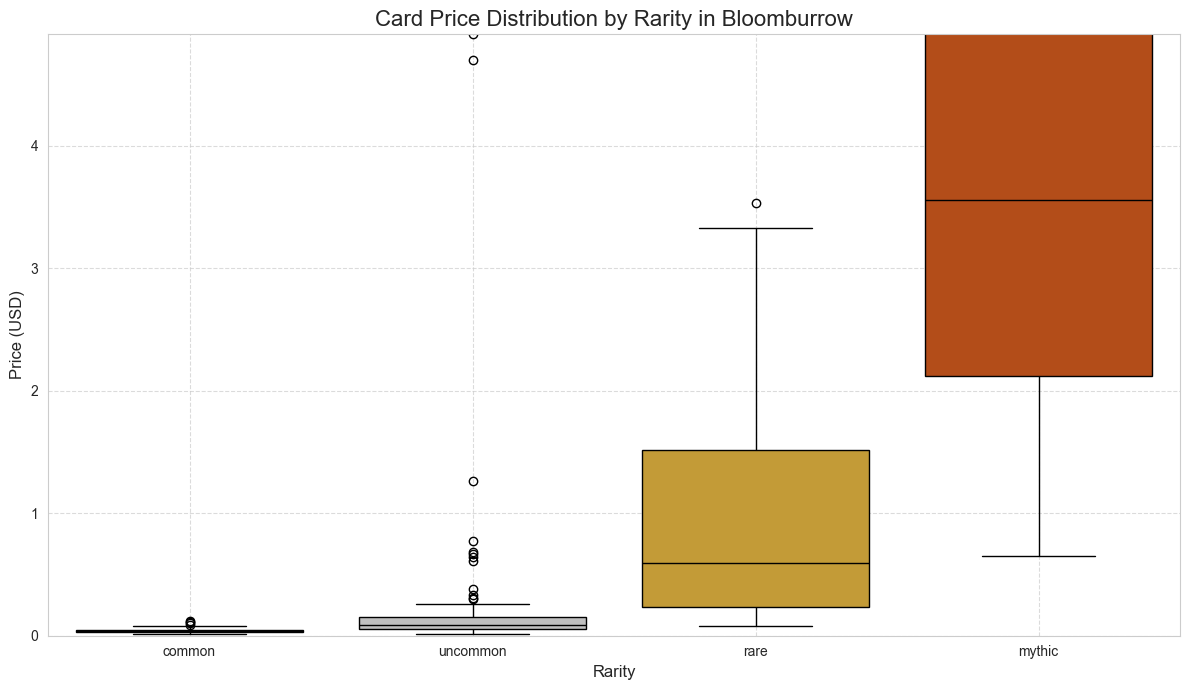

In [14]:
# Define the standard MTG rarity order for consistent plotting
rarity_order = ['common', 'uncommon', 'rare', 'mythic']
blb_df['rarity'] = pd.Categorical(blb_df['rarity'], categories=rarity_order, ordered=True)

# --- Define custom rarity colors based on MTG symbol structure (Adjusted) ---
rarity_colors = {
    'common': '#000000',   # Black (unchanged)
    'uncommon': '#C0C0C0', # Silver (standard silver, lighter)
    'rare': '#DAA520',     # Gold (a common MTG gold tone)
    'mythic': '#CC4400'    # Burnt Orange (instead of pure red)
}

plt.figure(figsize=(12, 7))

# Apply the custom color palette to the box plot and fix the FutureWarning
sns.boxplot(x='rarity', y='price', data=blb_df, palette=rarity_colors, hue='rarity', legend=False)

plt.title('Card Price Distribution by Rarity in Bloomburrow', fontsize=16)
plt.xlabel('Rarity', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
# Limit y-axis to focus on the bulk of data (e.g., up to the 95th percentile)
plt.ylim(0, blb_df['price'].quantile(0.95))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Price Distributions

That's a bit rough to read, but we can clearly see strong patterns. Commons max out around 10c. A few good uncommon cards retain some value. Mythic rares clearly are the most expensive, but still contain some "bulk mythics" ("bulk rares" and rare cards worth less than $1).

In [15]:
# Preprocessing for colors: Flatten the list of lists and count occurrences
all_colors = []
# Iterate through the 'colors' column, handling NaNs and ensuring list type
for card_colors in blb_df['colors'].dropna():
    if isinstance(card_colors, list):
        all_colors.extend(card_colors)
    elif isinstance(card_colors, str):
        try:
            # Try to convert string representation of list
            parsed_colors = ast.literal_eval(card_colors)
            if isinstance(parsed_colors, list):
                all_colors.extend(parsed_colors)
            else:
                # Handle cases where it's a single color string 'U' not ['U']
                all_colors.append(parsed_colors) 
        except (ValueError, SyntaxError):
            # If it's just a single color code like 'U' and not a list string
            all_colors.append(card_colors) # Add as is, assuming it's a color code

# Add 'Colorless' category for cards with empty 'colors' list/NaN
colorless_count = blb_df['colors'].apply(lambda x: len(x) == 0 if isinstance(x, list) else (pd.isna(x))).sum()
color_counts = pd.Series(all_colors).value_counts()

# Add 'Colorless' to the counts
if colorless_count > 0:
    color_counts['Colorless'] = color_counts.get('Colorless', 0) + colorless_count

# Sort colors for consistent pie chart ordering (WUBRG + Colorless/Multi)
# Define standard MTG color order
mtg_color_order = ['W', 'U', 'B', 'R', 'G', 'Colorless'] 
# Filter color_counts to only include keys in mtg_color_order, then reindex
color_counts_ordered = color_counts.reindex(mtg_color_order, fill_value=0)
# Add any other colors that might be present (e.g. if multi-color was included directly in 'colors')
for color in color_counts.index:
    if color not in mtg_color_order:
        color_counts_ordered[color] = color_counts[color]


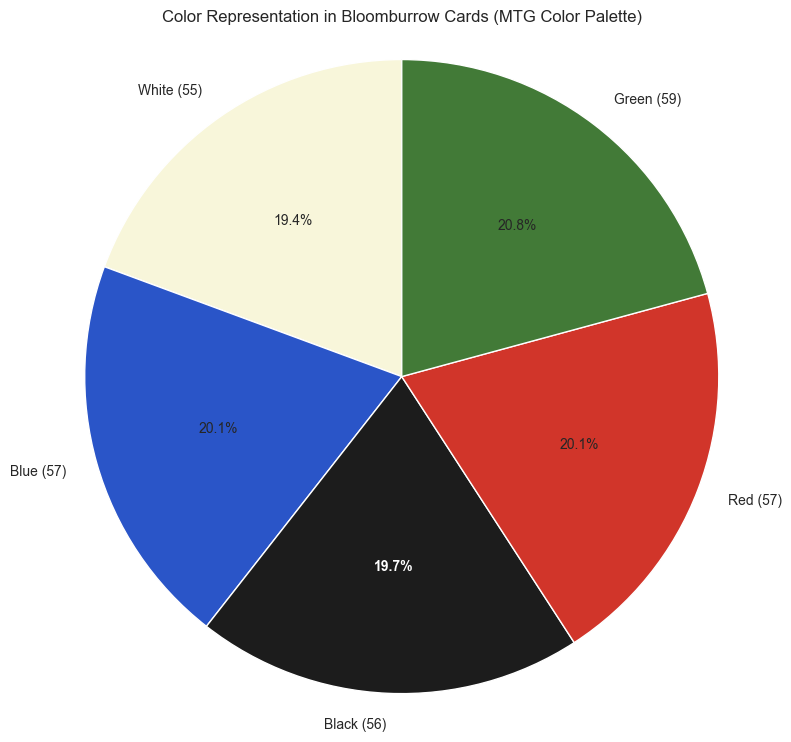

In [16]:

mtg_color_full_names = {
    'W': 'White',
    'U': 'Blue',
    'B': 'Black',
    'R': 'Red',
    'G': 'Green',
    'Colorless': 'Colorless',
}

# --- Define the MTG Custom Color Palette ---
mtg_colors_palette = {
    'W': '#F8F6DA',  # White (often represented as a creamy or light beige)
    'U': '#2A55C8',  # Blue (a classic, deep magic blue)
    'B': '#1C1C1C',  # Black (very dark grey or off-black)
    'R': '#D1352A',  # Red (a vibrant, fiery red)
    'G': '#427A37',  # Green (a rich, earthy green)
    'Colorless': '#A0A0A0', # A neutral grey for colorless cards
    # If you were to explicitly categorize 'Multicolor' cards as one group:
    # 'Multicolor': '#DAA520' # Gold
}

mtg_color_order = ['W', 'U', 'B', 'R', 'G', 'Colorless'] 

# Create an ordered Series of counts, filtering for colors present in the data and our palette
color_counts_ordered = color_counts.reindex(mtg_color_order, fill_value=0)

# Filter out colors that have 0 count to avoid empty slices and ensure correct labels/colors alignment
# Also, ensure only colors explicitly in our `mtg_colors_palette` are considered
present_colors_in_order = [
    color for color in mtg_color_order 
    if color_counts_ordered.get(color, 0) > 0 and color in mtg_colors_palette
]

counts_for_pie = color_counts_ordered[present_colors_in_order]

# Get the corresponding colors from our custom palette
colors_for_pie = [mtg_colors_palette[color] for color in present_colors_in_order]

# Percent and count labels
# Create labels for the pie chart using full color names and counts
labels_for_pie = [
    f"{mtg_color_full_names[color_abbr]} ({count})"
    for color_abbr, count in counts_for_pie.items()
]

plt.figure(figsize=(9, 9))
wedges, texts, autotexts = plt.pie(
    counts_for_pie,
    labels=labels_for_pie,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_for_pie
)

black_index = present_colors_in_order.index('B')
autotexts[black_index].set_color('white')
autotexts[black_index].set_weight('bold') # Optional: makes it bolder for contrast

plt.title('Color Representation in Bloomburrow Cards (MTG Color Palette)')
plt.axis('equal')
plt.show()


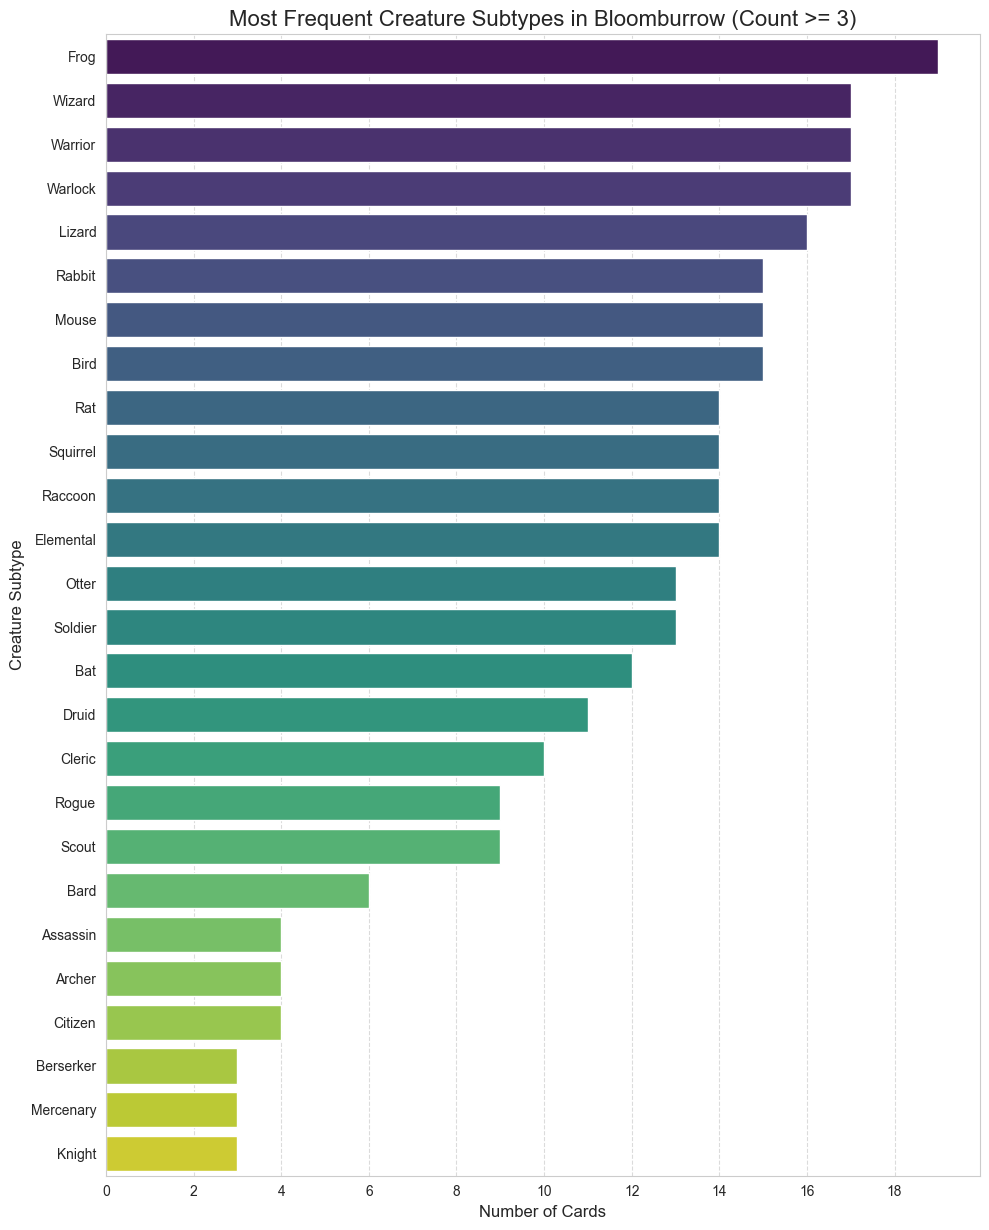

In [26]:
# Get a list of all creature types
creature_subtypes = []
for type_line in blb_df['type_line'].dropna():
    if 'Creature' in type_line:
        # Subtypes occur after the dash
        subtypes_part = type_line.split('—')[1].strip()
        current_subtypes = [s.strip() for s in subtypes_part.split(' ') if s.strip()]
        creature_subtypes.extend(current_subtypes)

subtype_counts = Counter(creature_subtypes)

# Filter out types with fewer than 3 occurrences
filtered_subtypes = {subtype: count for subtype, count in subtype_counts.items() if count >= 3}

# Put most common subtypes first
sorted_subtypes = sorted(filtered_subtypes.items(), key=lambda item: item[1], reverse=True)

# Extract labels (subtype names) and values (counts)
labels = [item[0] for item in sorted_subtypes]
values = [item[1] for item in sorted_subtypes]

plt.figure(figsize=(10, len(labels) * 0.4 + 2)) # Dynamic height based on number of labels, with a min height
sns.barplot(x=values, y=labels, hue=labels, palette='viridis', legend=False, order=labels)

plt.title('Most Frequent Creature Subtypes in Bloomburrow (Count >= 3)', fontsize=16)
plt.xlabel('Number of Cards', fontsize=12)
plt.ylabel('Creature Subtype', fontsize=12)
plt.xticks(fontsize=10)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True)) # Ensure integer ticks
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### Quick Notes

 * Most creatures have a 'race' type (Mouse, Otter) and a 'class' type (Assassin, Warlock, Knight)
 * The two-color tribes have become known in the MTG community by the Ravnica guilds. Selesnya is just the jargony/flavor term for Green/White.

In [ ]:
# --- Define a palette for two-color MTG tribes (Revised) ---
mtg_tribes_palette = {
    'WU': '#9BBFE0',  # Azorius Birds
    'UB': '#4A3B5C',  # Dimir Rats
    'BR': '#A84545',  # Rakdos Lizards
    'RG': '#8A7A3A',  # Gruul Raccoons
    'GW': '#9EB77A',  # Selesnya Rabbits
    'WB': '#5F5F5F',  # Orzhov Bats
    'UR': '#BB6BCC',  # Izzet Otters
    'BG': '#5A6F4A',  # Golgari Squirrels
    'RW': '#D8A05F',  # Boros Mice
    'GU': '#50C8B5',  # Simic Frogs
}

### Understanding the Bloomburrow Dataset

This project analyzes data from **Bloomburrow**, a Magic: The Gathering set uniquely focused on anthropomorphic animal characters. This design significantly shapes the creature types and color distributions we observe.

A core structural element of Bloomburrow is its **"Tribes"**: ten distinct animal species, each inherently tied to a specific two-color combination. These tribes serve as the set's primary **archetypes**. In the context of a card game, an **archetype** represents a defined strategic identity or playstyle. It's a blueprint for how cards are designed to interact and function together within a specific framework.

For players, "picking a tribe" means embracing a particular archetype, leading to specific card synergies and gameplay strategies. For set designers (and our data analysis), this tribal structure ensures cards are deliberately crafted to support these distinct groupings. This strong internal consistency within the tribes directly impacts the clusters and patterns of abilities, keywords, and overall card characteristics we see in our dataset.

The ten primary tribes and their associated two-color identities are:

* **Birds:** White-Blue (WU) - Flying/non-flying synergies
* **Rats:** Blue-Black (UB) - Threshold/graveyard mechanics
* **Lizards:** Black-Red (BR) - Opponent life loss
* **Raccoons:** Red-Green (RG) - Expend (Spending 4 or more mana)
* **Rabbits:** Green-White (GW) - Offspring/Abundance/tokens
* **Bats:** White-Black (WB) - Life gain/life loss
* **Otters:** Blue-Red (UR) - Non-creature spells
* **Squirrels:** Black-Green (BG) - Forage/graveyard mechanics
* **Mice:** Red-White (RW) - Valiant/fast aggression
* **Frogs:** Green-Blue (GU) - "Blink" mechanics

The patterns in our data, such as creature type prevalence and color usage, directly reflect these foundational design principles and the strategic roles of each Bloomburrow tribe.

---
Summary prepared by Gemini, edited.

#### Deeper Tribe Descriptions

For those who are interested and familiar with general MTG mechanics/concepts, we have prepared a deeper dive into these tribes. We'll describe the basic strategy of the deck, and provide a subjective evaluation of its relative strength in the meta. In draft, finding an 'open lane' is often more valuable than fighting over the strongest archetype. Rabbits are a very strong tribe, but if 3 people at the table are trying to draft them, none of those 3 people will do well. This effect inherently balances out the "weaker" tribes.

* **Birds:** Focuses on synergies between flying creatures and non-flying creatures; requires a good mix of both to succeed. Looks to close out the game with evasive creatures.
    - Tier: Mid/low
    - Bomb: Kastral, the Windcrested
    - Notable commons/uncommons: Plumecreed Escort (U), Plumecreed Mentor (U)
* **Rats:** Graveyard synergies, using Surveil to trigger Threshold. Relies on high-performing uncommons
    - Tier: Mid
    - Bomb: Vren, the Relentless
    - Notable commons/uncommons: **Shoreline Looter** (U), **Persistent Marshstalker** (U), Mindwhisker (U)
* **Lizards:** Aggressive deck that powers up creatures based on opponent life loss. All-in on aggression.
    - Tier: Mid
    - Bomb: **Gev, Scaled Scorch**, Hired Claw, Iridescent Vinelasher
    - Notable commons/uncommons: Flamecache Gecko (U), Thought-Stalker Warlock (U)
* **Raccoons:** Midrange deck; requires careful mana management to trigger expend.
    - Tier: Mid/low
    - Bomb: Keen-Eyed Curator, Scrapshooter
    - Notable commons/uncommons: Roughshod Duo (C), Bakersbane Duo (C), Teapot Slinger(U), Bark-Knuckle Boxer (U)
* **Rabbits:** Strength in numbers; focused on overwhelming opponents with many creature tokens. Many strong commons/uncommons.
    - Tier: Top (best)
    - Bomb: **Warren Warleader**, Pawpatch Recruit
    - Notable commons/uncommons: **Intrepid Rabbit** (C), Warren Elder (C), Head of the Homestead (C), Harvestrite Host (U)
* **Bats:** Life gain/loss synergies and evasion (flying). Aims to stall the game and grind out victory.
    - Tier: Top/mid
    - Bomb: Darkstar Augur; Essence Channeler; Zoraline, Cosmos Caller
    - Notable commons/uncommons: **Lifecreed Duo** (C), Starscape Cleric (U)
* **Otters:** Focused on non-creature spell synergies; requires a careful mix to succeed. Easy to flop.
    - Tier: Low
    - Bomb: Bria, Riptide Rogue
    - Notable commons/uncommons: Coruscation Mage (U), Tempest Angler (C)
* **Squirrels:** Graveyard synergies, midrange aggression, grinding efficiency. Forage and Food.
    - Tier: Top
    - Bomb: Camellia, the Seedmiser; Ygra, Eater of All
    - Notable commons/uncommons: Bakersbane Duo (C), Bushy Bodyguard (U), Curious Forager (U), **Vinereap Mentor** (U)
* **Mice:** Valiant keyword; needs a good mix of Valiant cards and enablers. Fast, all-in aggression.
    - Tier: Top
    - Bomb: Emberheart Challenger; Mabel, Heir to Cragflame; Manifold Mouse
    - Notable commons/uncommons: Intrepid Rabbit (C), **Heartfire Hero** (U)
* **Frogs:** Blink creatures in and out of play to abuse ETB abilities; "bouncy" theme. Mid-range.
    - Tier: Top/mid
    - Bomb: Clement, the Worrywort; Dreamdew Entrancer
    - Notable commons/uncommons: Stickytongue Sentinal (C), Pond Prophet (C), Three Tree Scribe (U), Long River Lurker (U)

Keep in mind that these are general descriptions; it's possible to have a Bat or Frog deck focused on early aggression, or a more mid-game focused Lizard deck. All tribes can be strong with the right cards. The "Duo" cards belong to two tribes; some creatures are so good outside their tribe they show up in other decks (Intrepid Rabbit).

In [19]:
blb_df['name'][blb_df['cmc'] == 0.0].values

array(['Fabled Passage', 'Fountainport', 'Hidden Grotto',
       'Lilypad Village', 'Lupinflower Village', 'Mudflat Village',
       'Oakhollow Village', 'Rockface Village', 'Three Tree City',
       'Uncharted Haven'], dtype=object)

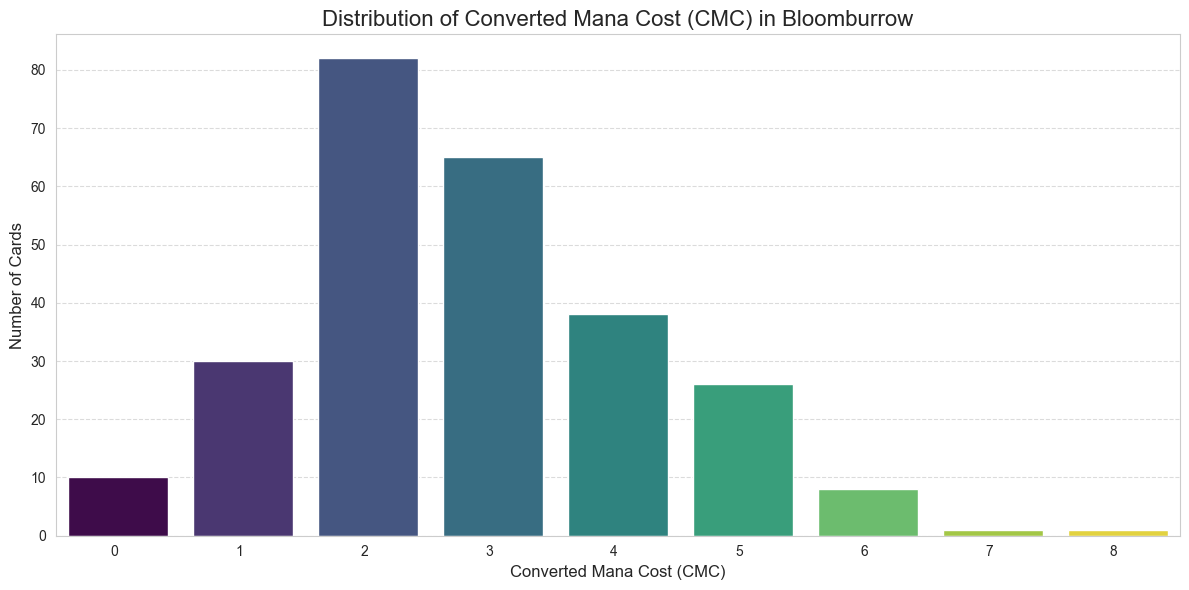

In [20]:
# CMC Distribution
cmc_counts = blb_df['cmc'].dropna().value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=cmc_counts.index, y=cmc_counts.values, hue=cmc_counts.index, palette='viridis', legend=False)

plt.title('Distribution of Converted Mana Cost (CMC) in Bloomburrow', fontsize=16)
plt.xlabel('Converted Mana Cost (CMC)', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)

plt.xticks(ha='right', fontsize=10) # Keep rotation and font size

# --- FIX: Use a locator for integer positions and a formatter for integer display ---
# This ensures Matplotlib picks integer tick locations AND formats them correctly,
# resolving the UserWarning and being more robust.
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d')) # Format as integer (e.g., 0 instead of 0.0)

plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [21]:
blb_df.columns

Index(['name', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'colors',
       'color_identity', 'keywords', 'reprint', 'rarity', 'penny_rank',
       'power', 'toughness', 'produced_mana', 'price'],
      dtype='object')

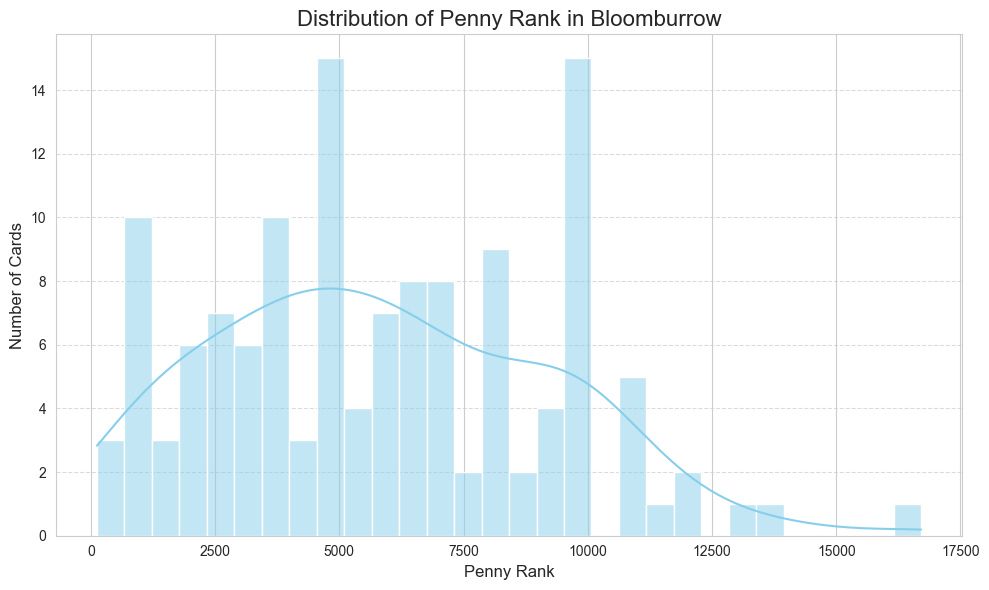

In [22]:
plt.figure(figsize=(10, 6))

# Create a histogram for 'penny_rank'
# sns.histplot automatically handles binning and aesthetics.
sns.histplot(data=blb_df, x='penny_rank', kde=True, bins=30, color='skyblue') # Added KDE for density estimation

plt.title('Distribution of Penny Rank in Bloomburrow', fontsize=16)
plt.xlabel('Penny Rank', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [23]:
# We assume 'type_line' column contains the card's types and look for 'Creature'.
creatures_df = blb_df[blb_df['type_line'].str.contains('Creature', na=False)].copy()

# 2. Convert 'power' and 'toughness' to numeric values
# Define a helper function to safely convert P/T strings to floats.
# It handles non-numeric values (like '*' or '-') by converting them to NaN.
def convert_pt_to_numeric(pt_str):
    try:
        return float(pt_str)
    except (ValueError, TypeError):
        return np.nan # Return NaN for non-numeric P/T (e.g., '*')

creatures_df['numeric_power'] = creatures_df['power'].apply(convert_pt_to_numeric)
creatures_df['numeric_toughness'] = creatures_df['toughness'].apply(convert_pt_to_numeric)

# 3. Calculate the average of numeric_power and numeric_toughness
creatures_df['avg_pt'] = (creatures_df['numeric_power'] + creatures_df['numeric_toughness']) / 2

# 4. Drop rows where 'avg_pt' or 'cmc' is NaN, as they cannot be plotted
df_for_scatter = creatures_df.dropna(subset=['avg_pt', 'cmc']).copy()

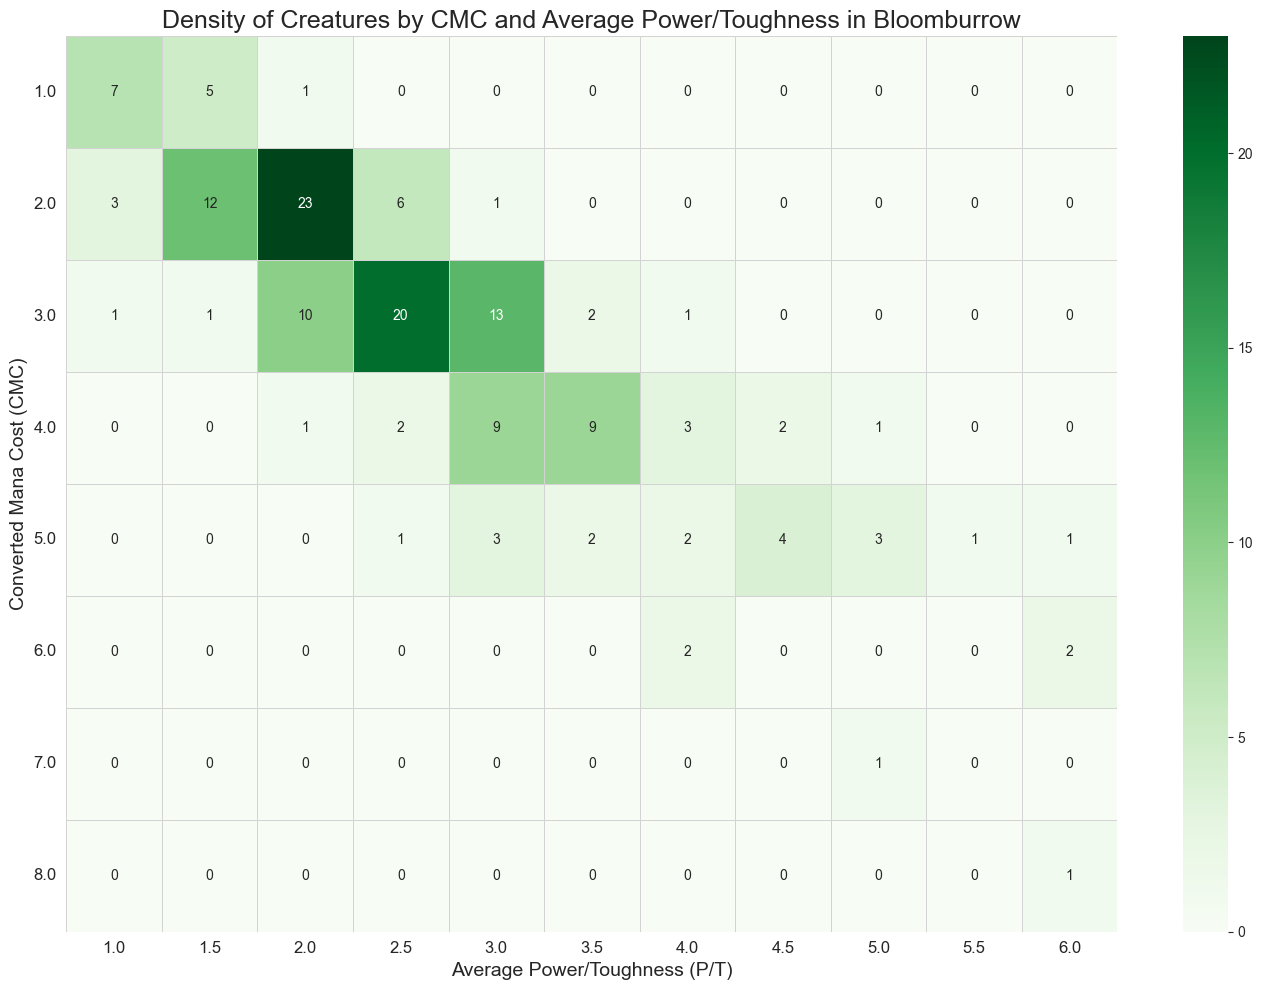

In [24]:
heatmap_data = df_for_scatter.groupby(['cmc', 'avg_pt']).size().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(columns=sorted(heatmap_data.columns))


# --- Plotting the Heatmap with Improved Colormap ---
plt.figure(figsize=(14, 10))

# Changed cmap to 'Greens' which starts with a very light color (almost white) for low values (0)
# and progresses to darker greens for higher counts.
sns.heatmap(heatmap_data, cmap='Greens', annot=True, fmt='d', linewidths=.5, linecolor='lightgray')

plt.title('Density of Creatures by CMC and Average Power/Toughness in Bloomburrow', fontsize=18)
plt.xlabel('Average Power/Toughness (P/T)', fontsize=14)
plt.ylabel('Converted Mana Cost (CMC)', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0) # Keep Y-axis labels horizontal for readability

plt.tight_layout()
plt.show()

### P/T Heatmap

Power and toughness are "core" creature stats that closely align with mana cost. We could basically never see a 5/4 for 2 mana, because that would unbalance the game. Similarly, no one would play a 2/2 for 7.

The standard "rate" is CMC = Power = Toughness. So a 5/4 for 4 would be considered "above rate" (more power or toughness is good, so you're getting a "good deal" with that card). Cards extremely far above or below the standard rate **always** have counterbalancing abilities or special use cases to make them playable.